In [124]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# plt.rcParams['font.sans-serif']=['Simhei']  #显示中文
# plt.rcParams['axes.unicode_minus']=False    #显示负号
%config InlineBackend.figure_format = 'retina'
from lmfit.models import LinearModel,VoigtModel,SplineModel

from scipy.signal import find_peaks
from peakutils import baseline

import os

path = 'figs/'

# Celibration

## Linear Celibrantion

In [77]:
os.listdir('data/beta/')

['10.chn',
 '10.txt',
 '15.chn',
 '15.txt',
 '18.8.chn',
 '18_8.txt',
 '20_8.chn',
 '20_8.txt',
 '5.chn',
 '5.txt',
 'beta.chn',
 'beta.txt',
 'brta.chn',
 'brta.txt']

In [78]:
txtfiles = ['5.txt','10.txt','15.txt','18_8.txt','20_8.txt']
data_dict = {txtfile:pd.read_csv('data/beta/' + txtfile, sep='\t')['1'].values \
             for txtfile in txtfiles}
data_linear_celibration = pd.DataFrame(data_dict)
data_linear_celibration.columns = ['5mV','10mV','15mV','18.8mV','20.8mV']
data_linear_celibration

,5mV,10mV,15mV,18.8mV,20.8mV
0,0,0,0,0,0
1,0,0,0,0,0
2,0,0,0,0,0
3,0,0,0,0,0
4,0,0,0,0,0
...,...,...,...,...,...
1019,0,0,0,0,0
1020,0,0,0,0,0
1021,0,0,0,0,0
1022,0,0,0,0,0


Text(0, 0.5, 'Count')

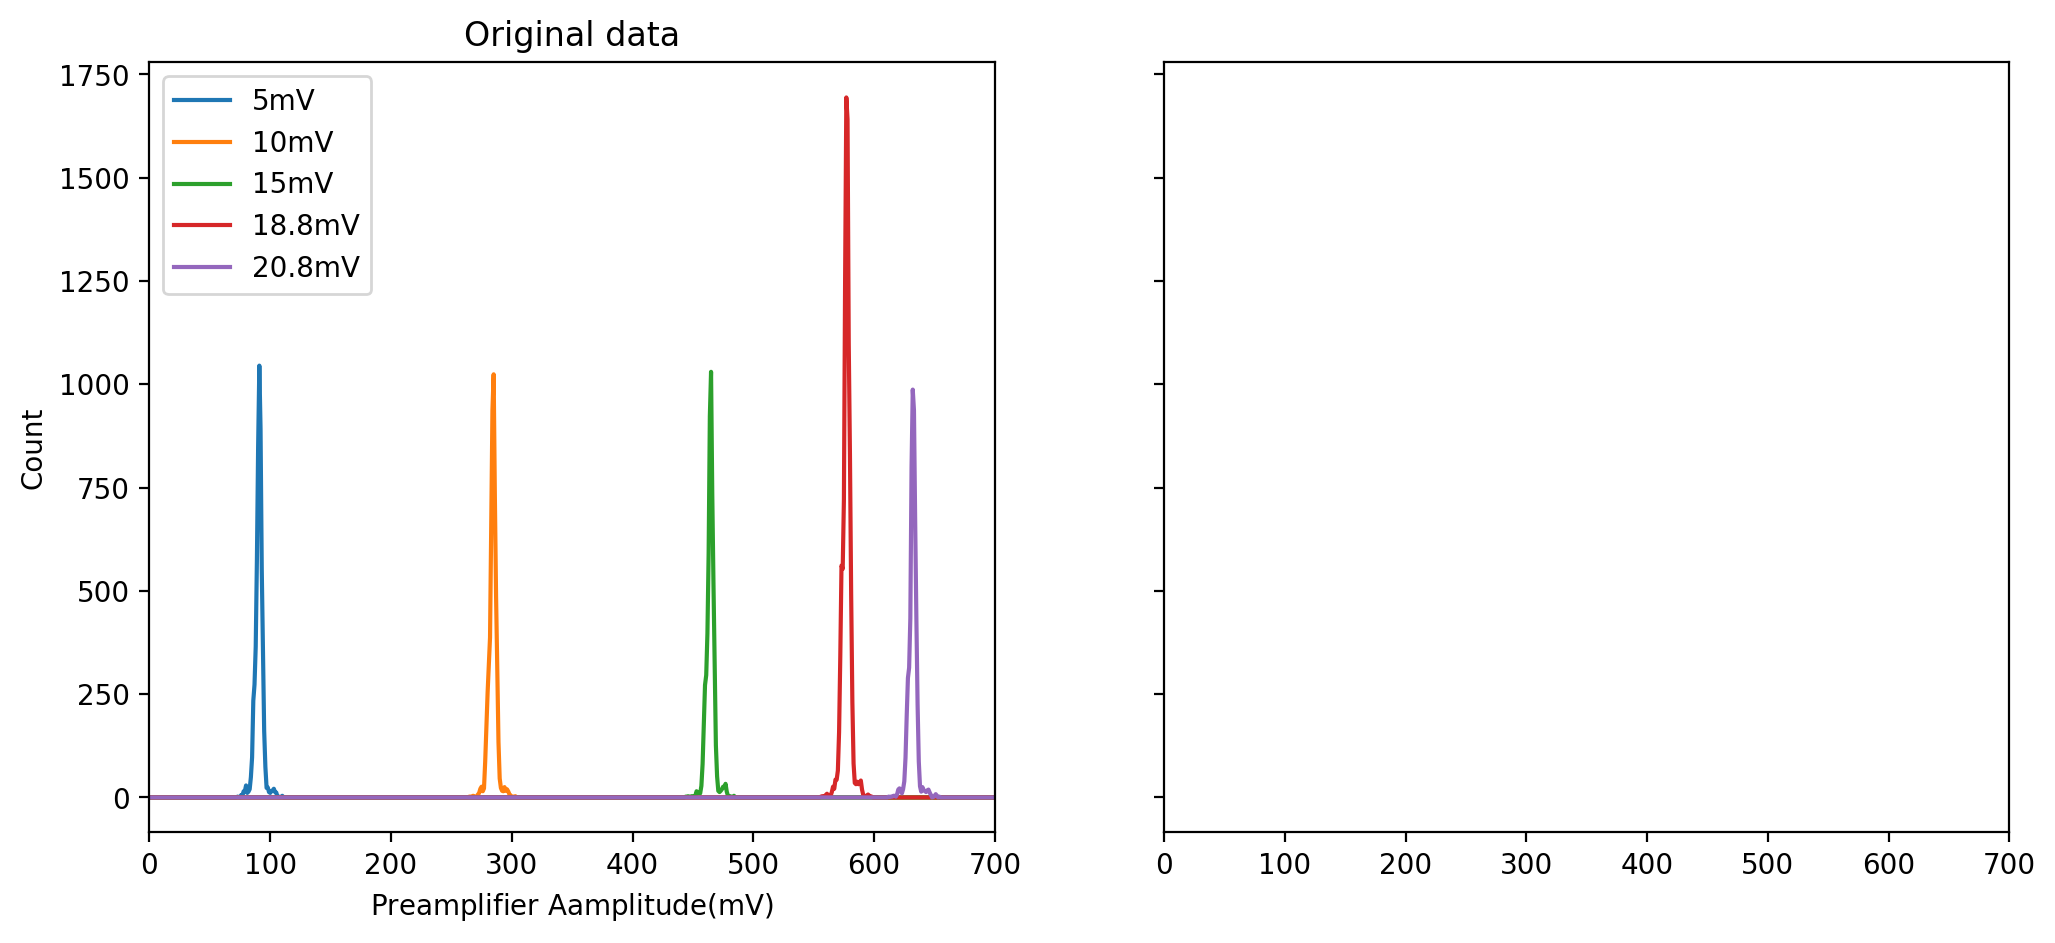

In [100]:
fig,axes = plt.subplots(1,2,figsize=(12,5),sharex=True,sharey=True)
data_linear_celibration.plot(ax = axes[0])
axes[0].set_xlim(0,700)
axes[0].set_title('Original data')
axes[0].set_xlabel(r'Preamplifier Aamplitude($\rm{mV}$)')
axes[0].set_ylabel('Count')

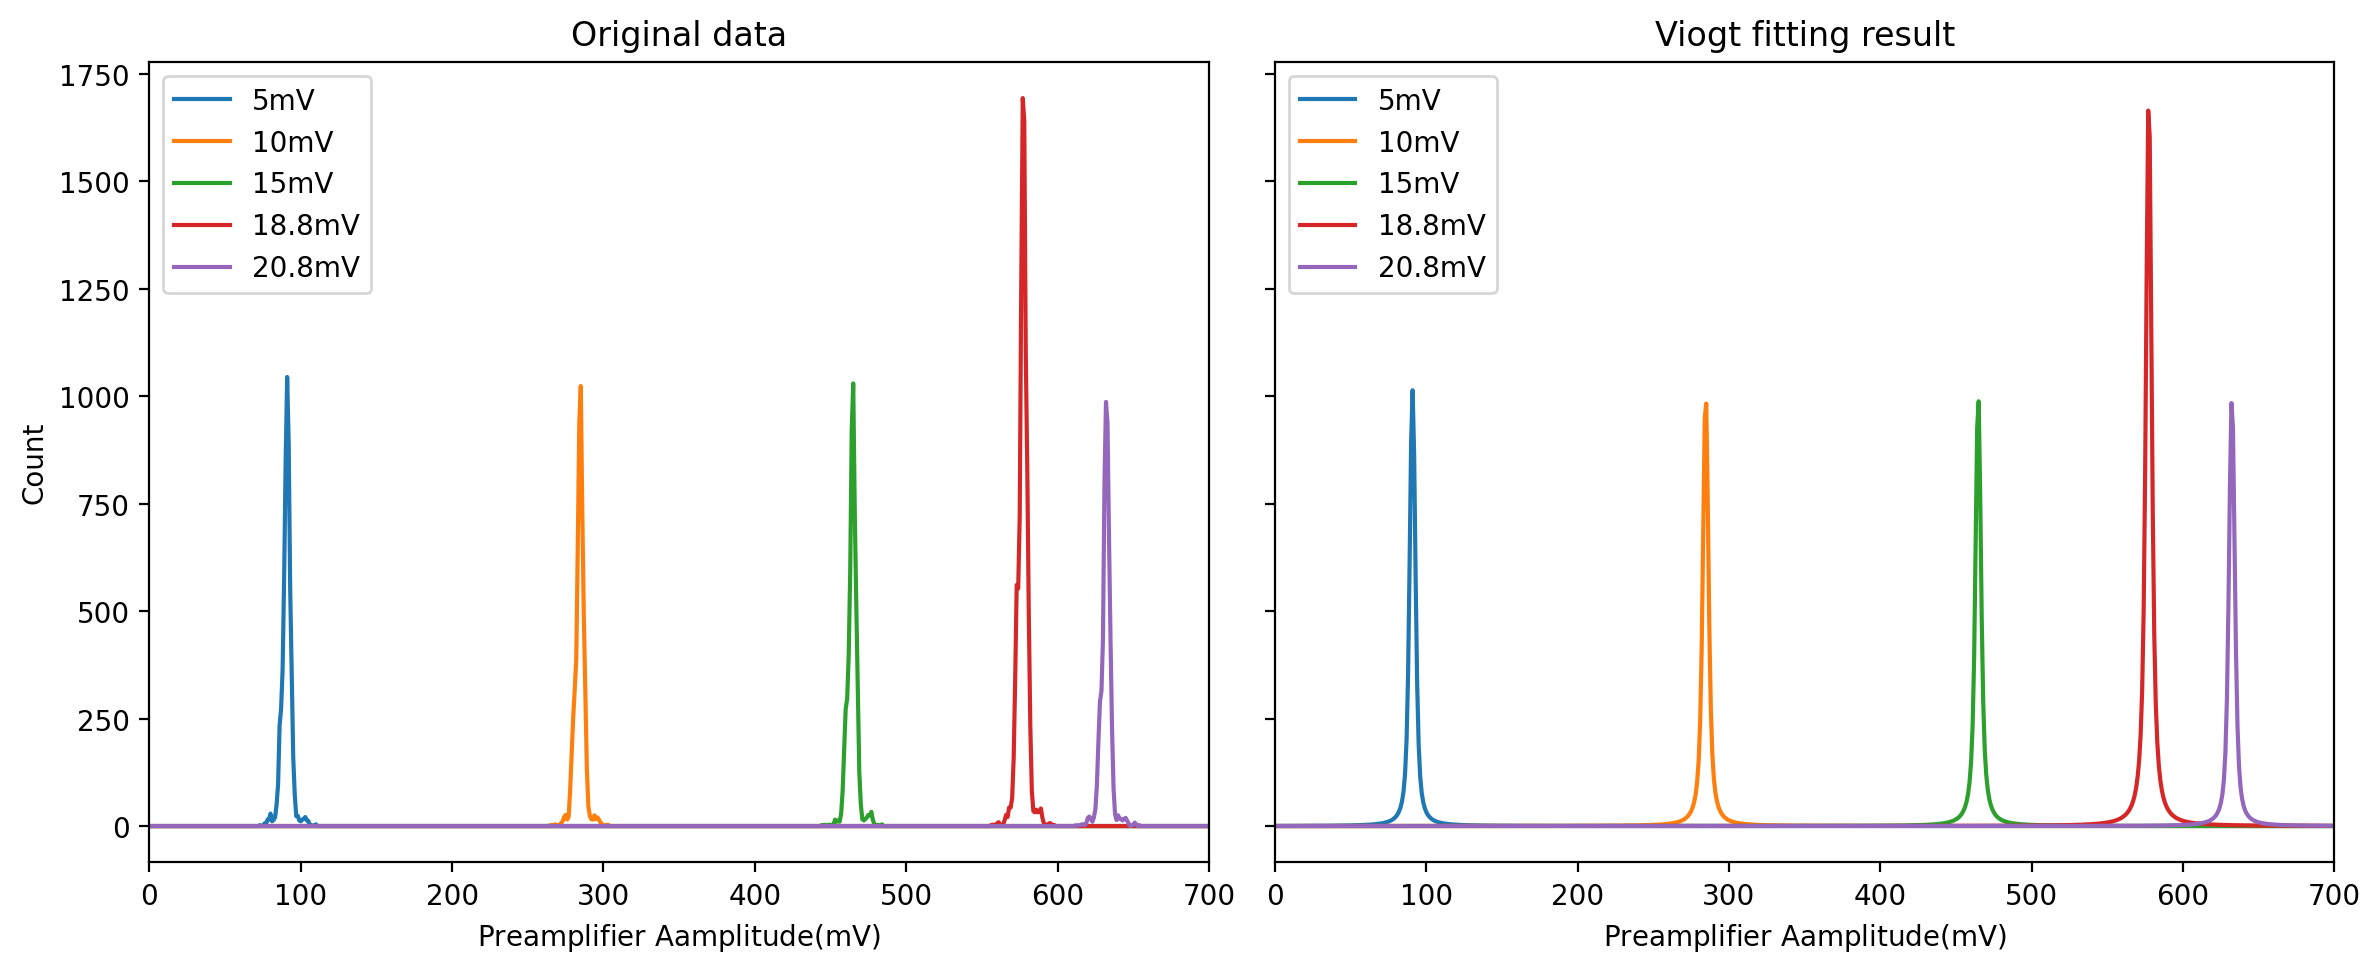

([91, 285, 465, 577, 632],
 [90.94315096147045,
  284.615449197184,
  464.69686662489113,
  577.3777226325575,
  632.286003704376])

In [101]:
peaks = []
peaks_voigt = []
for col in data_linear_celibration.columns:
    data = data_linear_celibration[col].values
    x_data = np.arange(0,len(data),1)
    peak,_ = find_peaks(data, prominence = 800 )
    peaks.append(peak[0])
    model = VoigtModel()
    params = model.guess(data, x=x_data)
    params['gamma'].set( vary=True)
    result = model.fit(data, params, x=x_data)
    peaks_voigt.append(result.params['center'].value)
    axes[1].plot(x_data, result.best_fit, label=col)

axes[1].set_title('Viogt fitting result')
axes[1].set_xlabel(r'Preamplifier Aamplitude($\rm{mV}$)')
axes[1].set_ylabel('Count')
axes[1].legend()
fig.tight_layout()
fig.savefig(path + 'linear_celibration.pdf')
display(fig)

peaks,peaks_voigt

[[Model]]
    Model(linear)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 7
    # data points      = 5
    # variables        = 2
    chi-square         = 752.959090
    reduced chi-square = 250.986363
    Akaike info crit   = 29.0728649
    Bayesian info crit = 28.2917407
    R-squared          = 0.99619596
[[Variables]]
    slope:      34.3364234 +/- 1.22502400 (3.57%) (init = 1)
    intercept: -67.9791756 +/- 18.4656267 (27.16%) (init = 0)
[[Correlations]] (unreported correlations are < 0.100)
    C(slope, intercept) = -0.9235


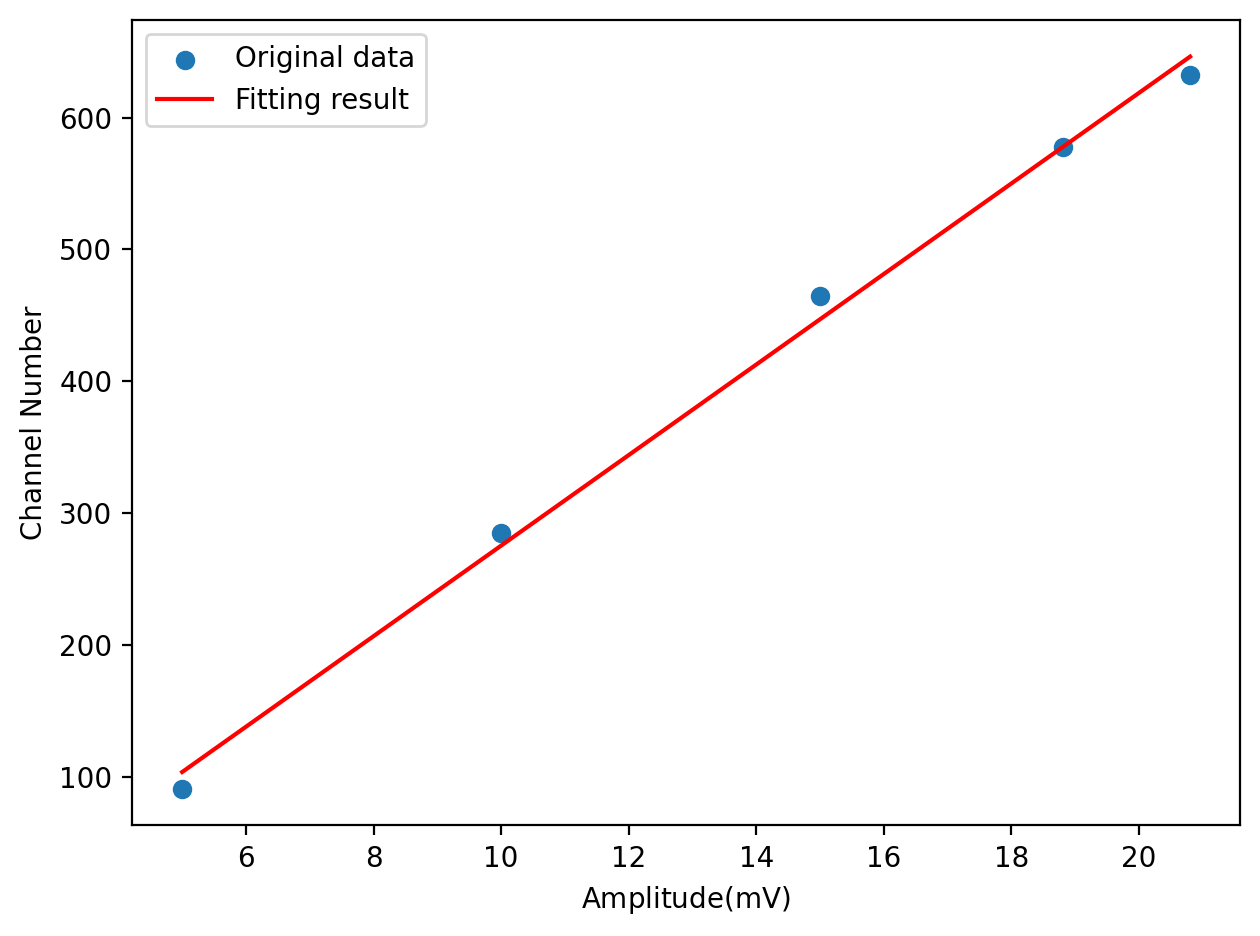

In [102]:
x = [eval(i[:-2]) for i in data_linear_celibration.columns]
y = peaks_voigt

linear_model = LinearModel()
fit_result = linear_model.fit(y, x=x)

print(fit_result.fit_report())

plt.scatter(x, y, label='Original data')
x_plot = np.linspace(min(x), max(x), 1001)
plt.plot(x_plot,
         fit_result.eval(x=x_plot),
         label='Fitting result', color='r')
plt.xlabel(r'Amplitude(${\rm mV}$)')
plt.ylabel(r'Channel Number')
plt.legend()
plt.tight_layout()
plt.savefig(path+'linear_fit.pdf')
plt.show()

In [103]:
celi_B = fit_result.params['slope'].value
celi_Bstderr = fit_result.params['slope'].stderr
print(celi_B,celi_Bstderr)

34.3364234408808 1.2250239979234592


## One Energy Celibration

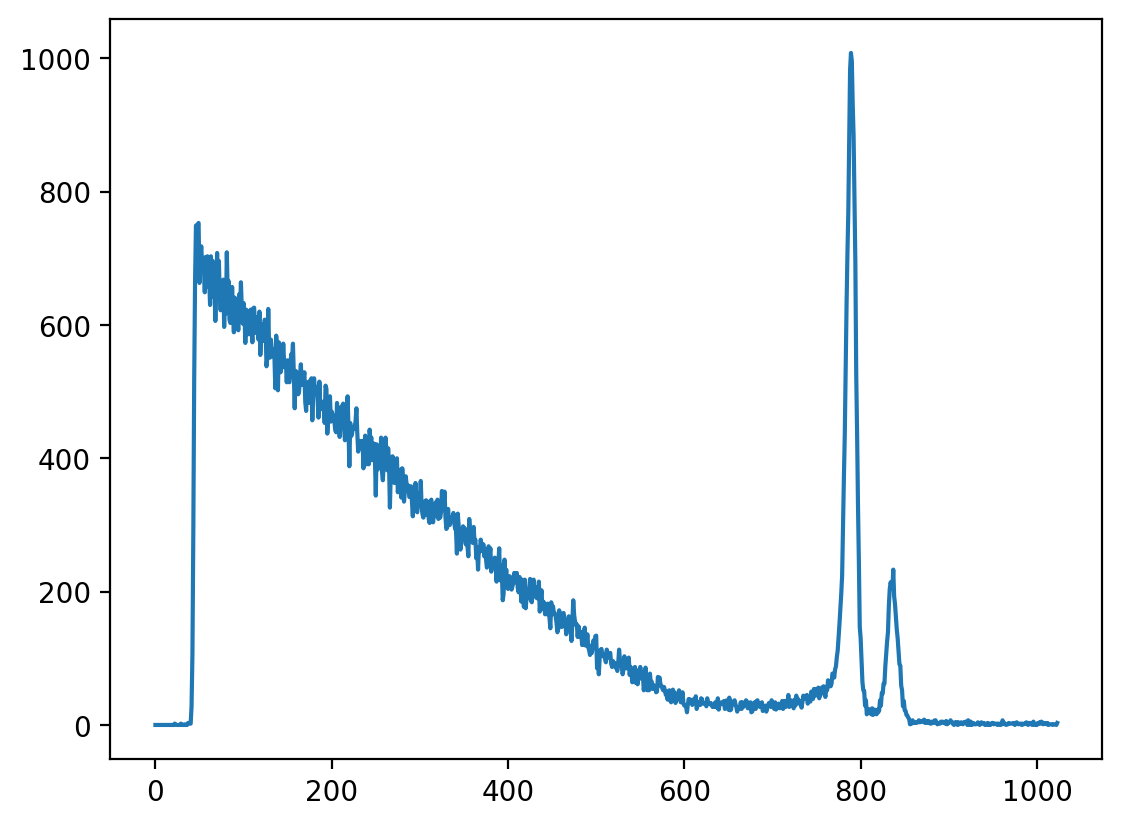

In [105]:
beta_spetrum = pd.read_csv('data/beta/beta.txt', sep='\t')['1'].values
plt.plot(beta_spetrum)
plt.show()

In [136]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.optimize import curve_fit

#data generation
# np.random.seed(123)
# data=np.concatenate((np.random.normal(1, .2, 5000), np.random.normal(1.6, .3, 2500)))
# y,x,_=plt.hist(data, 100, alpha=.3, label='data')
# x=(x[1:]+x[:-1])/2 # for len(x)==len(y)
y = beta_spetrum
x = np.arange(0,len(beta_spetrum),1)

#x, y inputs can be lists or 1D numpy arrays

def gauss(x, mu, sigma, A):
    return A*np.exp(-(x-mu)**2/2/sigma**2)

def bimodal(x, mu1, sigma1, A1, mu2, sigma2, A2):
    return gauss(x,mu1,sigma1,A1)+gauss(x,mu2,sigma2,A2)

expected = (790, .2, 1, 830, .2, 125)
params, cov = curve_fit(bimodal, x, y, expected)
sigma=np.sqrt(np.diag(cov))
x_fit = np.linspace(x.min(), x.max(), 500)
#plot combined...
plt.plot(x_fit, bimodal(x_fit, *params), color='red', lw=3, label='model')
#...and individual Gauss curves
plt.plot(x_fit, gauss(x_fit, *params[:3]), color='red', lw=1, ls="--", label='distribution 1')
plt.plot(x_fit, gauss(x_fit, *params[3:]), color='red', lw=1, ls=":", label='distribution 2')
#and the original data points if no histogram has been created before
#plt.scatter(x, y, marker="X", color="black", label="original data")
plt.legend()
print(pd.DataFrame(data={'params': params, 'sigma': sigma}, index=bimodal.__code__.co_varnames[1:]))
plt.show() 

RuntimeError: Optimal parameters not found: Number of calls to function has reached maxfev = 1400.

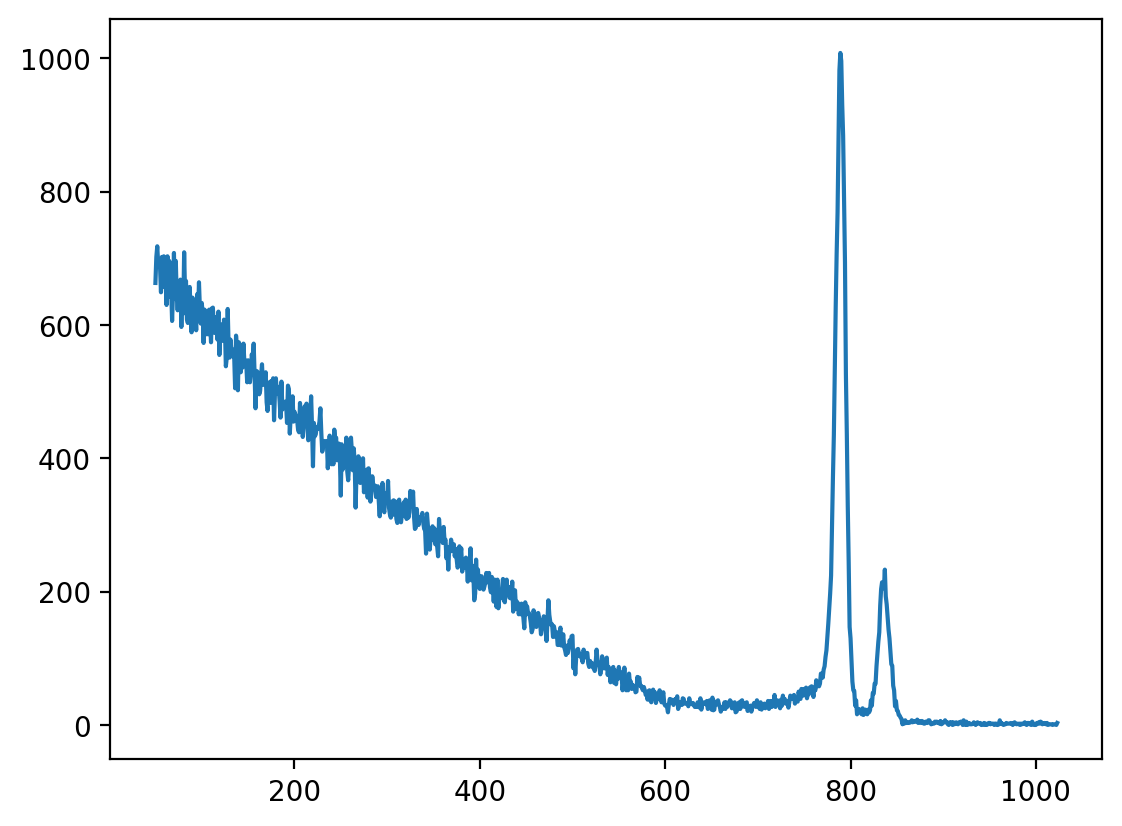

In [109]:
beta_spetrum_dropped = beta_spetrum[50:]
channel_dropped = np.arange(50,1024,1)
# bl = baseline(beta_spetrum[50:],deg=4)
# print(bl)
fig,ax = plt.subplots()
ax.plot(channel_dropped,beta_spetrum_dropped)

In [129]:
Viogt1 = VoigtModel(prefix='peak1_')
params = Viogt1.make_params(center={'value': 790, 'max': 800})
Viogt2 = VoigtModel(prefix='peak2_')
params.update(Viogt2.make_params(center={'value': 830, 'min': 800}))
params['peak1_gamma'].set(vary=True)
params['peak2_gamma'].set(vary=True)
# params
knot_xvals = np.arange(100,1100, 100)
bkg = SplineModel(prefix='bkg_', xknots=knot_xvals)
params.update(bkg.guess(beta_spetrum_dropped, channel_dropped))
params

name,value,initial value,min,max,vary,expression
peak1_amplitude,1.00000000,None,-inf,inf,True,
peak1_center,790.000000,790,-inf,800.000000,True,
peak1_sigma,1.00000000,None,0.00000000,inf,True,
peak1_gamma,-inf,None,-inf,inf,True,
peak1_fwhm,nan,None,-inf,inf,False,1.0692*peak1_gamma+sqrt(0.8664*peak1_gamma**2+5.545083*peak1_sigma**2)
peak1_height,nan,None,-inf,inf,False,"(peak1_amplitude/(max(1e-15, peak1_sigma*sqrt(2*pi))))*real(wofz((1j*peak1_gamma)/(max(1e-15, peak1_sigma*sqrt(2)))))"
peak2_amplitude,1.00000000,None,-inf,inf,True,
peak2_center,830.000000,830,800.000000,inf,True,
peak2_sigma,1.00000000,None,0.00000000,inf,True,
peak2_gamma,-inf,None,-inf,inf,True,


In [131]:
model = Viogt1 + Viogt2 + bkg
out = model.fit(beta_spetrum_dropped, params, x=beta_spetrum_dropped)
print(out.fit_report())

ValueError: The model function generated NaN values and the fit aborted! Please check your model function and/or set boundaries on parameters where applicable. In cases like this, using "nan_policy='omit'" will probably not work.

In [ ]:
peaks = []
peaks_voigt = []
for col in data_linear_celibration.columns:
    data = data_linear_celibration[col].values
    x_data = np.arange(0,len(data),1)
    peak,_ = find_peaks(data, prominence = 800 )
    peaks.append(peak[0])
    model = VoigtModel()
    params = model.guess(data, x=x_data)
    result = model.fit(data, params, x=x_data)
    peaks_voigt.append(result.params['center'].value)
    axes[1].plot(x_data, result.best_fit, label=col)

axes[1].legend()
# display(fig)
peaks,peaks_voigt



([91, 285, 465, 577, 632],
 [90.94249703095655,
  284.61131941978664,
  464.69153572846994,
  577.3758902284803,
  632.2856125252595])

In [ ]:
peaks = []
peaks_voigt = []
for col in data_linear_celibration.columns:
    data = data_linear_celibration[col].values
    x_data = np.arange(0,len(data),1)
    peak,_ = find_peaks(data, prominence = 800 )
    peaks.append(peak[0])
    model = VoigtModel()
    params = model.guess(data, x=x_data)
    result = model.fit(data, params, x=x_data)
    peaks_voigt.append(result.params['center'].value)
    axes[1].plot(x_data, result.best_fit, label=col)

axes[1].legend()
# display(fig)
peaks,peaks_voigt



([91, 285, 465, 577, 632],
 [90.94249703095655,
  284.61131941978664,
  464.69153572846994,
  577.3758902284803,
  632.2856125252595])

In [88]:
peak,info = find_peaks(beta_spetrum,prominence=1000)
peak

array([789], dtype=int64)

# RAW

[[Model]]
    Model(linear)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 7
    # data points      = 5
    # variables        = 2
    chi-square         = 533.195196
    reduced chi-square = 177.731732
    Akaike info crit   = 27.3472483
    Bayesian info crit = 26.5661242
    R-squared          = 0.99730143
[[Variables]]
    slope:      36.0186453 +/- 1.08173468 (3.00%) (init = 1)
    intercept: -82.7350679 +/- 15.9540281 (19.28%) (init = 0)
[[Correlations]] (unreported correlations are < 0.100)
    C(slope, intercept) = -0.9275


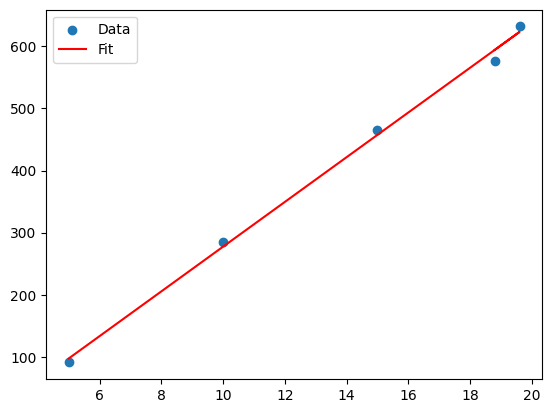

In [2]:
from lmfit.models import LinearModel
import matplotlib.pyplot as plt

# Create data
x = [18.8,19.6,15.0,10.0,5.0]
y = [577,632,465,285,91]

# Initialize the linear model and fit the data
linear_model = LinearModel()
fit_result = linear_model.fit(y, x=x)

# Print the fit report
print(fit_result.fit_report())

# Plot the data and fitted line
plt.scatter(x, y, label='Data')
plt.plot(x, fit_result.best_fit, label='Fit', color='r')
plt.legend()
plt.show()

In [17]:
import pandas as pd

# Given data
x = [18.8, 19.6, 15.0, 10.0, 5.0]
y = [577, 632, 465, 285, 91]

# Create a DataFrame
data = {r'amplitude(mV)': x, 'Peak_position': y}
df = pd.DataFrame(data)

# Display the DataFrame
df.to_csv('linear_celibration.csv')

In [12]:
fit_result